# JackKnife W/ Kmeans

Here I develop a class to make $N_{\rm patches}$ using the `kmeans_radec` code.

### Use ClevarEnv To Load Kmeans
!pip install --user git+https://github.com/esheldon/kmeans_radec.git

In [1]:
import numpy as np, time, astropy.io.fits, os, sys
import matplotlib.pylab as plt

In [2]:
import kmeans_radec
from kmeans_radec import KMeans, kmeans_sample


## Load Data

In [3]:
# Fname Setup
path = '/project/projectdirs/des/www/y3_cats/'
rm_fname = path+'y3_gold_2.2.1_wide_sofcol_run_redmapper_v0.5.1_redmagic_12_3_19.h5'

columns = ['mem_match_id','ra','dec','z_lambda','lambda_chisq']
path_rm = 'catalog/redmapper/lgt5'
path_ran = 'randoms/redmapper/lgt5'


In [4]:
print('load data')
from astropy.table import Table
import h5py
def read_hdf5(fname, path, columns=None):
    """Read the hdf5 files for a given path
    if columns is None read all columns
    """
    h5  = h5py.File(fname,'r+')
    h5group = h5[path]
    if columns is None: columns = list(h5group.keys())
    
    out = dict()
    for col in columns:
        out[col] = h5group[col][:]
    
    return out

rm = Table(read_hdf5(rm_fname, 'catalog/redmapper/lgt5', columns=columns))
ran = Table(read_hdf5(rm_fname, 'randoms/redmapper/lgt5', columns=None))

# 20 times the rm catalog
Nran = int(20*len(rm))
ix = np.random.randint(len(ran), size=Nran)
ran = ran[ix]

load data


In [5]:
ra = np.array(rm['ra'])
dec = np.array(rm['dec'])

In [6]:
from jackEstimatorKmeans import JackKniferKmeans


In [7]:
print('Start JK Estimator')
Npatches = 10
jk =  JackKniferKmeans(rm['ra'], rm['dec'], Npatches)
jk.show_stats()
# jk.write(fname_kmeans_centers)

# random group labels
ran_labels = jk.add_randoms(ran['ra'],ran['dec'])


Start JK Estimator
Number of patches:  10
Cluster Sizes:  [23883 25546  6690 26700 30946 33378 33657 31734 29156 14791]
Labels:  [8 8 8 ... 2 2 2]


# JackKnifer

In [213]:
class JackKniferKMeans(object):
    """
    Define the Jackknife labels using Kmeans
    
    Args:
        Npatches (int): number of patches
        pos (array): sky mask.
        frac_thr (float): minimum fraction of a given jackknife region
            that must be unmasked for that region to be included in
            the set of regions.
    """
    def __init__(self, ra, dec, npatches, frac_thr=0.8):
        self.pos = np.vstack([ra,dec]).T
        self.npatches = npatches
        self.frac_th = frac_thr
        self.fit_centers()
        
        # assign label and cluster size variables
        self.labels = self.km.labels
        self.cluster_sizes = np.bincount(self.km.labels)
        
    def fit_centers(self, verbose=0):
        km = kmeans_sample(self.pos, ncen=self.npatches, verbose=verbose, maxiter=100)

        # check convergence
        if not km.converged:
            print('Kmeans did not converge with 100 iterations')
            print('Trying with an undefined number of iterations')
            km.run(pos)
        
        self.km = km
        pass
    
    def show_stats(self):
        print('Number of patches: ', self.npatches)
        print('Cluster Sizes: ', self.cluster_sizes)
        print('Labels: ', self.labels)

    def get_mask(self, k_id):
        mask = self.labels != k_id
        return mask
    
    def add_randoms(self, ra, dec):
        pos_ran = np.vstack([ra,dec]).T
        return self.km.find_naearest(pos_ran)
    
    def refit_centers(self, centers=None):
        if centers is None: centers = self.km.centers
        self.km.set_centers()
        self.km.run(self.pos)
        self.update()
        
    def update(self):
        self.labels = self.km.labels
        self.cluster_sizes = np.bincount(self.km.labels)
        
    def plot_groups(self, Npoints=10000):
        plot_proj(self.pos[:,0], self.pos[:,1], self.labels, Npoints=Npoints)
    
    def plot_groups_masked(self, k_id, Npoints=10000):
        plt.clf()
        mask = self.get_mask(k_id)
        plot_proj(self.pos[mask,0], self.pos[mask,1], self.labels[mask], Npoints=Npoints)

In [214]:
import skymapper as skm

def plot_proj(ra, dec, labels, Npoints=10000):
    idx = np.random.randint(len(ra), size=Npoints)
    # define the best Albers projection for the footprint
    # minimizing the variation in distortion
    crit = skm.stdDistortion
    proj = skm.WagnerIV.optimize(ra[idx], dec[idx], crit=crit)

    # construct map: will hold figure and projection
    # the outline of the sphere can be styled with kwargs for matplotlib Polygon
    map = skm.Map(proj)

    # add graticules, separated by 15 deg
    # the lines can be styled with kwargs for matplotlib Line2D
    # additional arguments for formatting the graticule labels
    sep=15
    map.grid(sep=sep,)

    # add scatter plot
    map.scatter(ra[idx], dec[idx], c=labels[idx], cmap='tab20', s=25, edgecolor='w', facecolor='None')


    # # focus on relevant region
    map.focus(ra[idx], dec[idx], pad=0.1)

    map.title('DES K-Means')
    
    # hide x-ticks
    ax = map.ax
    labels = [item.get_text() for item in ax.get_xticklabels()]

    empty_string_labels = ['']*len(labels)
    ax.set_xticklabels(empty_string_labels)
    

In [253]:
jk = JackKniferKMeans(ra, dec, 100)

In [254]:
jk.show_stats()

Number of patches:  100
Cluster Sizes:  [3283 2597 2732 2177 2731 2451 2455 2204 2254 2488 2856 2373 2572 2611
 2156 3009 2688 3221 2615 2562 2979 2216 1897 2545 2321 2369 3212 2665
 2953 2149 2935 2714 3680 2538 2638 2905 2174 2420 2461 2612 1872 2574
 2570 2346 1947 2670 2780 2184 2886 2221 2103 3273 1953 3150 2307 2376
 1943 2662 2590 2993 2430 2665 2704 2450 2371 2376 2619 2321 2285 2981
 2248 2872 1891 2944 2765 2307 2482 2849 3186 3123 2559 2334 2597 2962
 2507 3058 2523 2439 2119 3354 2329 2799 2384 2746 2501 2728 2368 2368
 1997 2122]
Labels:  [22 22 22 ... 72 72 72]


optimizing parameters of WagnerIV to minimize stdDistortion
best objective 0.090810 at WagnerIV(13.32024787300691)


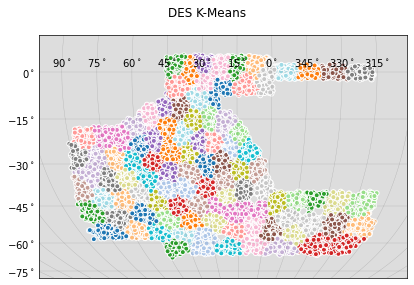

In [255]:
jk.plot_groups()

optimizing parameters of WagnerIV to minimize stdDistortion
best objective 0.088106 at WagnerIV(11.302385913874055)


<Figure size 432x288 with 0 Axes>

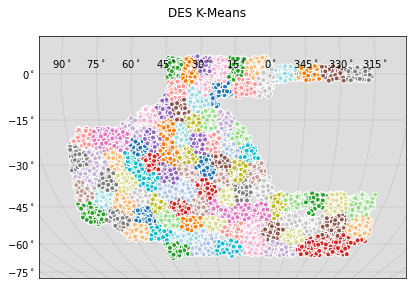

In [256]:
jk.plot_groups_masked(4)

In [257]:
new_labels = jk.add_randoms(ran['ra'], ran['dec'])

In [275]:
# plt.hist(new_labels, bins=np.arange(jk.npatches)+1)
# plot_proj(X2[:,0], X2[:,1], new_labels, Npoints=10000)

In [276]:
# plt.hist(jk.labels, bins=np.arange(jk.npatches)+1)

In [277]:
frac_th = 0.6

frac = jk.cluster_sizes/np.median(jk.cluster_sizes)
bad_groups = np.where(np.abs(1-frac)>=(1-frac_th))[0]
bad_groups

array([32])

Text(0.5, 1.0, 'Average Fraction Of Objectes In Each Patch')

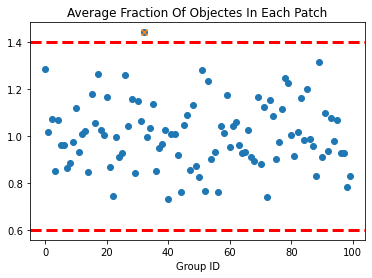

In [278]:
plt.scatter(range(jk.npatches),frac)
plt.scatter(bad_groups,frac[bad_groups],marker='x')
plt.axhline(frac_th,color='r',lw=3, ls='--')
plt.axhline(2-frac_th,color='r',lw=3, ls='--')

plt.xlabel('Group ID')
plt.title('Average Fraction Of Objectes In Each Patch')

In [279]:
def get_good_groups(self, frac_var=0.4):
    frac = self.cluster_sizes/np.median(self.cluster_sizes)
    good_patches = np.where(np.abs(frac-1)>= frac_var)[0]
    return good_patches